# Self Driving Car Engineer Project 4 - Advanced Lane Line Detection</h1>
**Benjamin Söllner**

<br />
<div id="toc"></div>

In [209]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Useful Packages, Configuration, and Helper Functions

In [335]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
TEST_IMAGES = glob.glob('test_images/*.jpg')
TEST_COLS = 3
CAL_PICKLE_FILE = "pickles/cal.p" 
CAL_TEST_IMAGE = "camera_cal/calibration1.jpg"
THRESH_TEST_IMAGE = "test_images/test5.jpg"
THRESH_MAG = (10, 130)
THRESH_DIR = (0.6, 1.2)
THRESH_S = (10, 100)
UNWARP_PLANE = [(604,440), (671,440), (1064,660), (226,660)]
UNWARP_X_OFFSET = 350
UNWARP_Y_OFFSET = 50
UNWARP_TEST_IMAGE = "test_images/straight_lines1.jpg"

# Function to run all test images through function and display them
def run_all_test_images(processing_function, cmap='rgb'):
    global TEST_IMAGES
    figure, plots = plt.subplots(int(np.ceil(len(TEST_IMAGES)/TEST_COLS)), 3, figsize=(20,10))
    for i, image_name in enumerate(TEST_IMAGES):
        image = cv2.imread(image_name)
        plots[int(i/TEST_COLS)][i%TEST_COLS].imshow(processing_function(image), cmap=cmap)
        plots[int(i/TEST_COLS)][i%TEST_COLS].set_title(ntpath.basename(image_name), fontsize=30)

## Calibrating Camera

### Finding Chessboard Corners

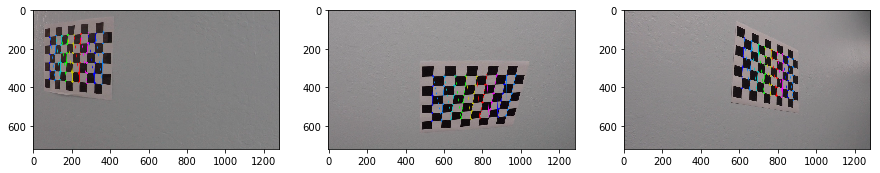

In [69]:
import glob
import ntpath
import itertools
%matplotlib inline

# number of rows and cols on the checkerboard
cal_rows = 6
cal_cols = 9

# prepare object points (3-dimensional), like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
cal_refpoints = np.zeros((cal_rows*cal_cols,3), np.float32)
cal_refpoints[:,:2] = np.mgrid[0:cal_rows, 0:cal_cols].T.reshape(-1,2)

# all object and image points
cal_objpoints = [] # 3d points in real world space
cal_imgpoints = [] # 2d points in image plane.

# list of calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
cal_no_checkboard_images = 3
cal_checkboard_images = []
for index, file in enumerate(cal_images):
    image = cv2.imread(file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    returncode, corners = cv2.findChessboardCorners(gray, (cal_rows,cal_cols), None)
    # If found, add object and found image points
    if returncode == True:
        cal_objpoints.append(cal_refpoints)
        cal_imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(image, (cal_rows, cal_cols), corners, returncode)
        output_name = 'debug_images/corners_found_'+ntpath.basename(file)
        cv2.imwrite(output_name, image)
        if len(cal_checkboard_images) < cal_no_checkboard_images:
            cal_checkboard_images.append(image)
        
# Visualize undistortion
figure, plots = plt.subplots(1, cal_no_checkboard_images, figsize=(15,10))
for plot, image in itertools.zip_longest(plots, cal_checkboard_images, fillvalue=None):
    if image is not None:
        plot.imshow(image)

### Calculating & Storing Distortion Parameters

In [210]:
import pickle
%matplotlib inline

# Test undistortion on an image
cal_test_image = cv2.imread('camera_cal/calibration1.jpg')
cal_test_image_size = (cal_test_image.shape[1], cal_test_image.shape[0])

# Do camera calibration given object points and image points
cal_ret, cal_matrix, cal_dist, cal_rvecs, cal_tvecs = \
    cv2.calibrateCamera(cal_objpoints, cal_imgpoints, cal_test_image_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
CAL_PICKLE = {"matrix": cal_matrix, "dist": cal_dist}
pickle.dump( CAL_PICKLE, open( CAL_PICKLE_FILE, "wb" ) )

### Undistortion

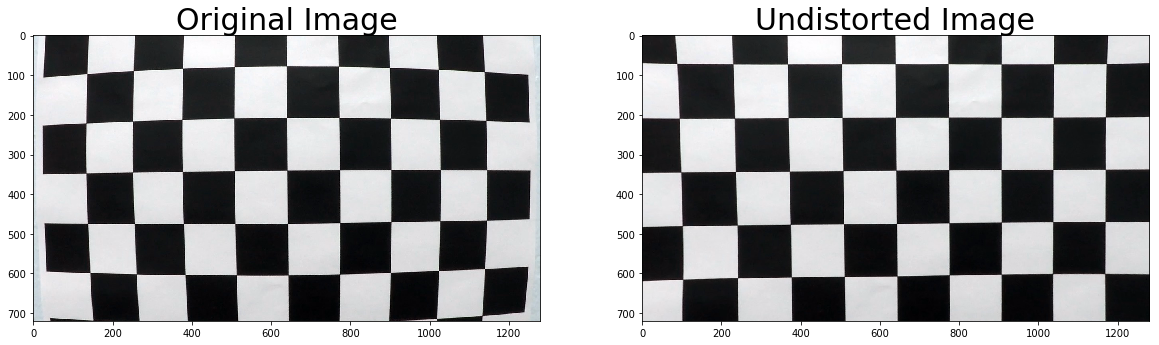

In [280]:
import pickle
%matplotlib inline

CAL_PICKLE = pickle.load(open( CAL_PICKLE_FILE, "rb" ))

def undistort(image):
    global CAL_PICKLE
    return cv2.undistort(image, cal_pickle["matrix"], cal_pickle["dist"], None, cal_pickle["matrix"])

# Test and visualize undistortion
cal_test_image = cv2.imread(CAL_TEST_IMAGE)
cal_test_undistort = undistort(cal_test_image)
cv2.imwrite('debug_images/test_undistort.jpg',cal_test_undistort)

# Visualize undistortion
figure, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,10))
plot1.imshow(cal_test_image)
plot1.set_title('Original Image', fontsize=30)
plot2.imshow(cal_test_undistort)
plot2.set_title('Undistorted Image', fontsize=30)

## Identifying Lane Line Pixels

### Color & Gradient Threshold

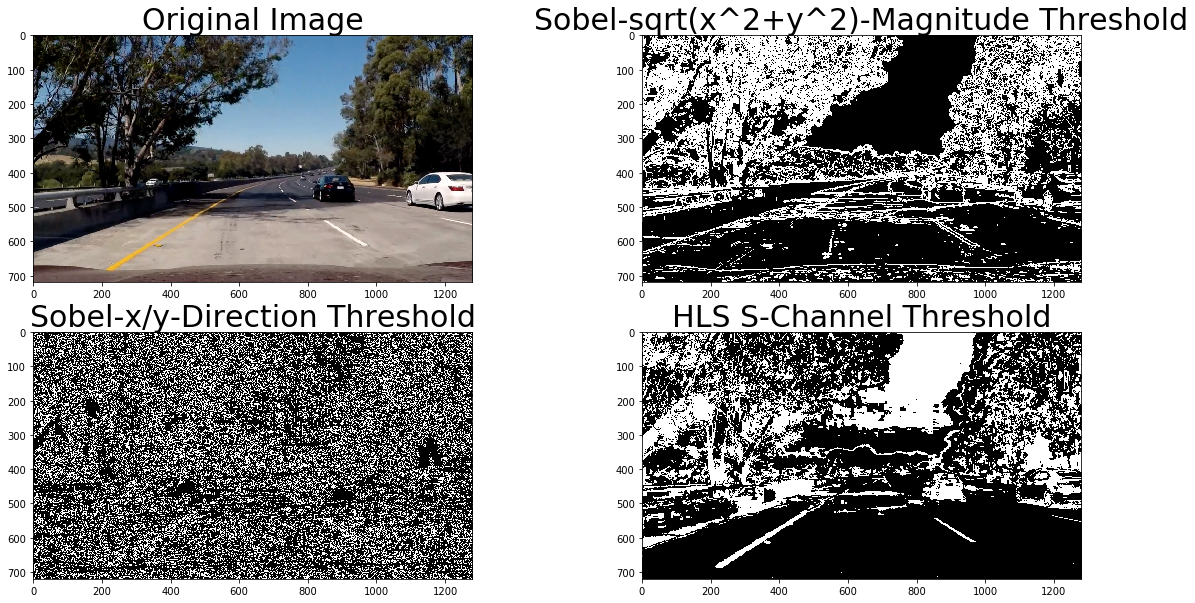

In [341]:
# applies Sobel x and y, then computes the magnitude of the gradient and applies a threshold
def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    # Create a binary mask where mag thresholds are met
    mask = np.zeros_like(grad_mag)
    mask[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask

# applies Sobel x and y, then computes the direction of the gradient and applies a threshold.
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    mask =  np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask

# thresholds the S-channel of HLS; use exclusive lower bound (>) and inclusive upper (<=)
def s_threshold(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s = hls[:,:,2]
    mask = np.zeros_like(s)
    mask[(s <= thresh[0]) | (s > thresh[1])] = 1
    # Return a binary image of threshold result
    return mask

# Test and Visualize Different thresholds
thresh_test_image = cv2.cvtColor(cv2.imread(THRESH_TEST_IMAGE), cv2.COLOR_BGR2RGB)
figure, plots = plt.subplots(2, 2, figsize=(20,10))
plots[0,0].imshow(thresh_test_image)
plots[0,0].set_title('Original Image', fontsize=30)
plots[0,1].imshow(mag_threshold(thresh_test_image, mag_thresh=THRESH_MAG), cmap='gray')
plots[0,1].set_title('Sobel-sqrt(x^2+y^2)-Magnitude Threshold', fontsize=30)
plots[1,0].imshow(dir_threshold(thresh_test_image, thresh=THRESH_DIR), cmap='gray')
plots[1,0].set_title('Sobel-x/y-Direction Threshold', fontsize=30)
plots[1,1].imshow(s_threshold(thresh_test_image, thresh=THRESH_S), cmap='gray')
plots[1,1].set_title('HLS S-Channel Threshold', fontsize=30)


### Combining Filters

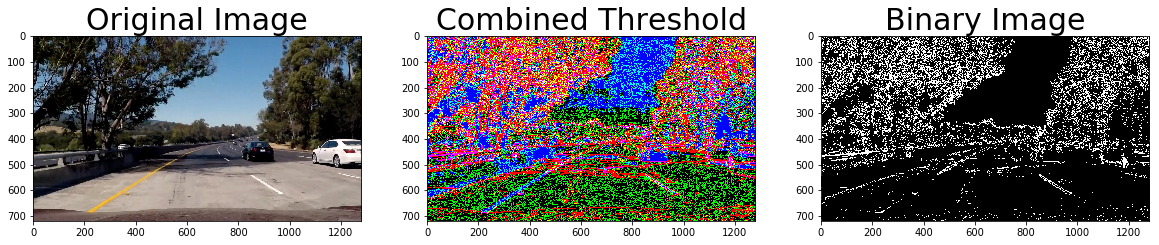

In [342]:
def combined_threshold(image):
    global THRESH_MAG
    global THRESH_DIR
    global THRESH_S
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    m = mag_threshold(image, mag_thresh=THRESH_MAG)
    d = dir_threshold(image, thresh=THRESH_DIR)
    s = s_threshold(image, thresh=THRESH_S)
    color_binary = np.dstack((m, d, s))
    return color_binary

def find_lane_line_pixels(image):
    combined = combined_threshold(image)
    m = combined[:,:,0].astype(int)
    d = combined[:,:,1].astype(int)
    s = combined[:,:,2].astype(int)
    # Require that at least two filters score
    binary = m & (s | d)
    return binary.astype(float)

# Test and Visualize Combined thresholds
thresh_test_image = cv2.cvtColor(cv2.imread(THRESH_TEST_IMAGE), cv2.COLOR_BGR2RGB)
figure, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].imshow(thresh_test_image)
plots[0].set_title('Original Image', fontsize=30)
plots[1].imshow(combined_threshold(thresh_test_image))
plots[1].set_title('Combined Threshold', fontsize=30)
plots[2].imshow(find_lane_line_pixels(thresh_test_image), cmap='gray')
plots[2].set_title('Binary Image', fontsize=30)



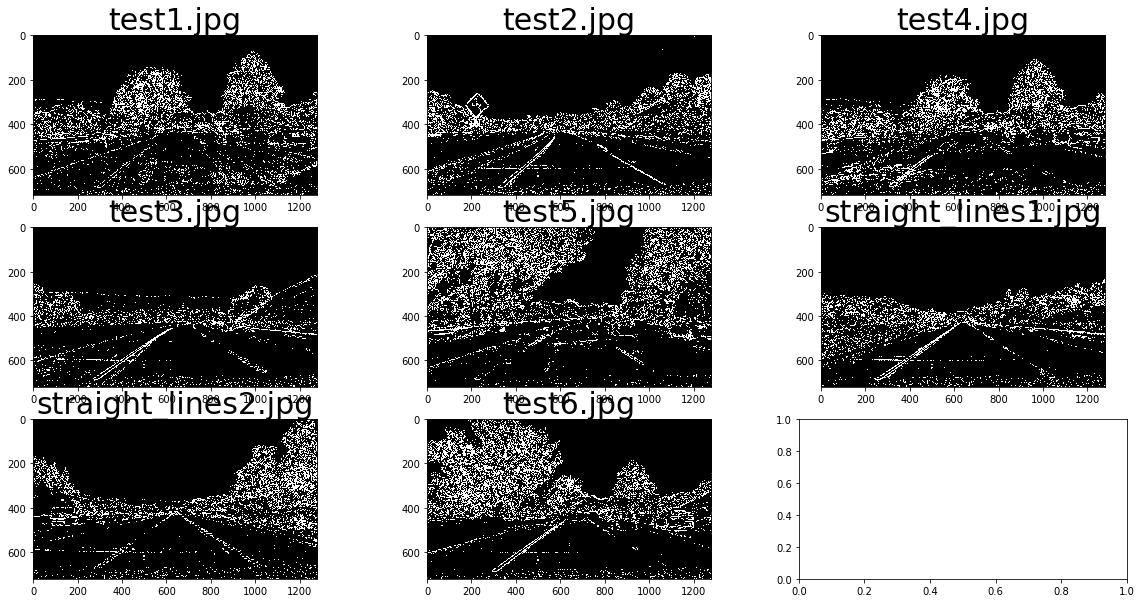

In [343]:
# Test and Visualize Combined thresholds
run_all_test_images(find_lane_line_pixels, cmap='gray')

## Perspective Transformation

### Undistorting & Unwarping

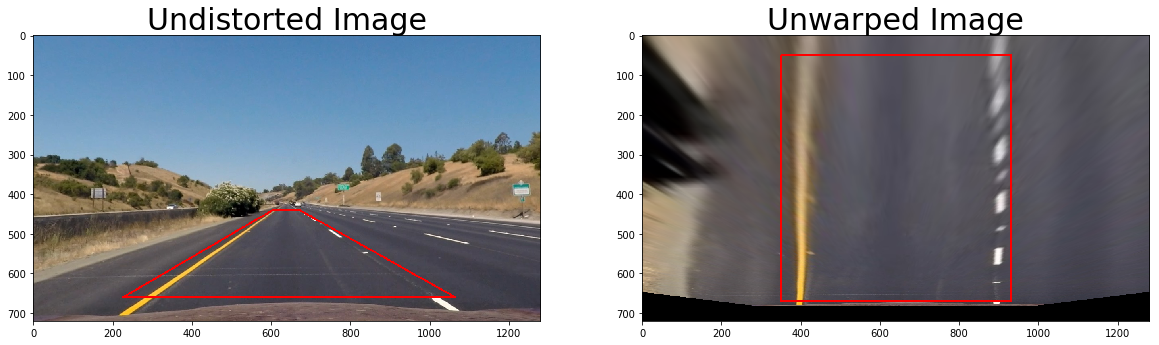

In [336]:
def show_lane_plane(image):
    global UNWARP_PLANE
    undistorted = undistort(image)
    color = [255,0,0]
    for (start, end) in zip([0,1,2,3], [1,2,3,0]):
        cv2.line(undistorted, UNWARP_PLANE[start], UNWARP_PLANE[end], [255,0,0], 3)
    return undistorted
    
def unwarp(image, show_plane=False):
    global UNWARP_PLANE
    global UNWARP_X_OFFSET
    global UNWARP_Y_OFFSET
    undistorted = undistort(image)
    source = UNWARP_PLANE
    x_offset = UNWARP_X_OFFSET 
    y_offset = UNWARP_Y_OFFSET 
    dim = (gray.shape[1], gray.shape[0])
    dest = [(x_offset, y_offset), (dim[0]-x_offset, y_offset), 
            (dim[0]-x_offset, dim[1]-y_offset), (x_offset, dim[1]-y_offset)]
    transform_matrix = cv2.getPerspectiveTransform(np.float32(source), np.float32(dest))
    unwarped = cv2.warpPerspective(undistorted, transform_matrix, dim, flags=cv2.INTER_LINEAR)
    if show_plane:
        for (start, end) in zip([0,1,2,3], [1,2,3,0]):
            cv2.line(unwarped, dest[start], dest[end], [255,0,0], 3)
    return unwarped, transform_matrix

# Test and Visualize Unwarping
unwarp_test_image = cv2.cvtColor(cv2.imread(UNWARP_TEST_IMAGE), cv2.COLOR_BGR2RGB)
figure, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].imshow(show_lane_plane(unwarp_test_image))
plots[0].set_title('Undistorted Image', fontsize=30)
plots[1].imshow(unwarp(unwarp_test_image, show_plane=True)[0])
plots[1].set_title('Unwarped Image', fontsize=30)


### Combining Perspective Transformation with Lane Line Pixel Detection 

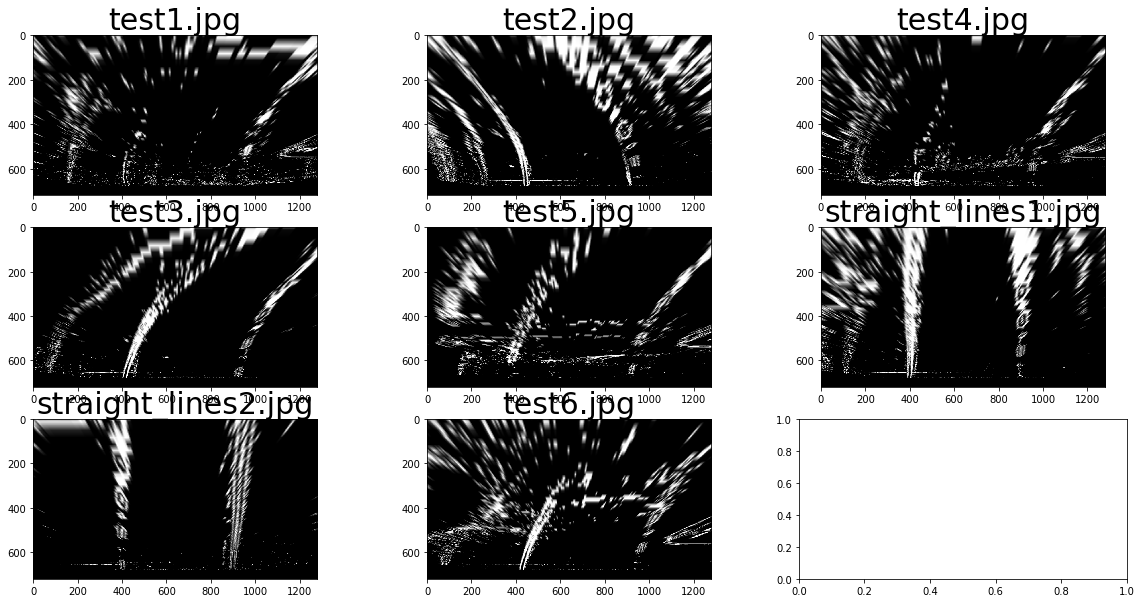

In [344]:
def unwarp_and_find(image):
    return unwarp(find_lane_line_pixels(image))[0]

# Test and Visualize Combined thresholds
run_all_test_images(unwarp_and_find, cmap='gray')
